In [ ]:
# Classfication model

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt


In [6]:

# Example: load from GitHub raw CSV
url = "https://raw.githubusercontent.com/sharmaroshan/Heart-UCI-Dataset/master/heart.csv"
df = pd.read_csv(url)
print(df.head(), df.shape)  # Expect 303 rows and 14 columns

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1   (303, 14)


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


✅ Logistic Regression
Best AUC Score: nan
Best Parameters: {'clf__C': 0.01, 'clf__penalty': 'l1'}
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


✅ Random Forest
Best AUC Score: nan
Best Parameters: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and 

✅ Gradient Boosting
Best AUC Score: nan
Best Parameters: {'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 100}
--------------------------------------------------

🎯 Classification Report:
              precision    recall  f1-score   support

           0      0.459     1.000     0.629        28
           1      0.000     0.000     0.000        33

    accuracy                          0.459        61
   macro avg      0.230     0.500     0.315        61
weighted avg      0.211     0.459     0.289        61

Confusion Matrix:
 [[28  0]
 [33  0]]
Test ROC-AUC: 0.5


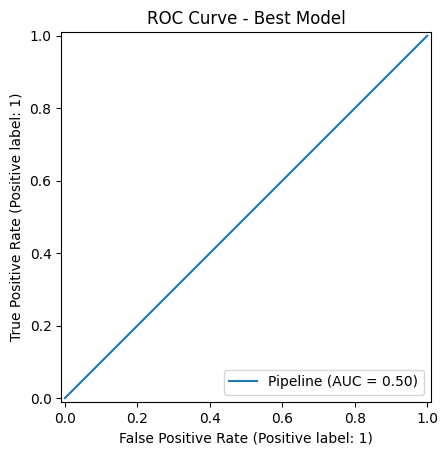

In [7]:


# Assuming the column name is indeed 'target' and the error was transient or a copy-paste issue.
# If the output of df.columns shows a different name, replace "target" below with the correct name.
X = df.drop("target", axis=1)
y = df["target"]

# Handle potential NaN values in the target variable before splitting
# Drop rows where the target variable 'y' is NaN
# This is necessary for stratification in train_test_split
nan_in_y_mask = y.isna()
if nan_in_y_mask.any():
    print(f"Warning: Found {nan_in_y_mask.sum()} rows with NaN in the target variable 'Gender'. These rows will be dropped.")
    X = X[~nan_in_y_mask]
    y = y[~nan_in_y_mask]

# Step 2: Preprocessing
num_cols = ['age','trestbps','chol','thalach','oldpeak']
cat_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']

preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first'), cat_cols)
])

# Step 3: Define models and hyperparameters
log_reg = Pipeline([
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=500, solver='liblinear'))
])
rf_clf = Pipeline([
    ('prep', preprocess),
    ('clf', RandomForestClassifier(random_state=42))
])
gb_clf = Pipeline([
    ('prep', preprocess),
    ('clf', GradientBoostingClassifier(random_state=42))
])

log_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1', 'l2']
}
rf_grid = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [None, 4, 6],
    'clf__min_samples_split': [2, 5]
}
gb_grid = {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__max_depth': [2, 3, 4]
}

# Step 4: GridSearchCV setup
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

searches = {
    'Logistic Regression': GridSearchCV(log_reg, log_grid, cv=cv, scoring='roc_auc', n_jobs=-1),
    'Random Forest': GridSearchCV(rf_clf, rf_grid, cv=cv, scoring='roc_auc', n_jobs=-1),
    'Gradient Boosting': GridSearchCV(gb_clf, gb_grid, cv=cv, scoring='roc_auc', n_jobs=-1)
}

# Now y does not contain NaN values, so stratification will work
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Step 5: Run all models
for name, search in searches.items():
    search.fit(X_train, y_train)
    print(f"✅ {name}")
    print(f"Best AUC Score: {search.best_score_:.4f}")
    print("Best Parameters:", search.best_params_)
    print("-" * 50)

# Step 6: Evaluate best model
best_model = max(searches.values(), key=lambda x: x.best_score_).best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\n🎯 Classification Report:")
print(classification_report(y_test, y_pred, digits=3))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba).round(3))

# Step 7: Plot ROC Curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("ROC Curve - Best Model")
plt.show()

